<a href="https://colab.research.google.com/github/dvoils/neural-network-experiments/blob/main/ion_channels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Ion Channel Dynamics

## Introduction to Detailed Neuron Models

This section provides an in-depth look at how detailed ion channel dynamics affect the behavior of spiking neurons. Building upon the foundational Hodgkin-Huxley (HH) framework, we explore how additional ion channels—particularly A-type potassium currents—introduce new functional properties like spike delay and adaptation.

## Canonical Hodgkin-Huxley Model

The Hodgkin-Huxley model describes the dynamics of a neuron's membrane potential $u(t)$ through a set of ordinary differential equations (ODEs). It includes three main ionic currents:

* **Sodium current (Na⁺):**
  $I_{\text{Na}} = \bar{g}_{\text{Na}} m^3 h (u - E_{\text{Na}})$

* **Potassium current (K⁺):**
  $I_{\text{K}} = \bar{g}_{\text{K}} n^4 (u - E_{\text{K}})$

* **Leak current:**
  $I_{\text{L}} = \bar{g}_{\text{L}} (u - E_{\text{L}})$

Each gating variable $x \in \{m, h, n\}$ evolves as:

$\frac{dx}{dt} = \frac{x_\infty(u) - x}{\tau_x(u)}$

These equations define the voltage-dependent steady-state value $x_\infty(u)$ and the time constant $\tau_x(u)$, capturing the rate of channel activation or inactivation.

We also included the explicitly defined **persistent sodium current**:

$I_{\text{NaP}} = \bar{g}_{\text{NaP}} m (u - E_{\text{Na}})$

This current is notable for its lack of inactivation and its role in promoting sustained depolarization.

## Characterizing Ion Channel Behavior

The activation ($m_\infty$) and inactivation ($h_\infty$) properties of various ion channels can be described in terms of their voltage-dependent steady-state values and time constants ($\tau_m$, $\tau_h$). These functions determine how quickly and under what conditions ion channels open or close in response to changes in membrane potential. The qualitative behaviors of these channels can be compared based on their characteristic activation thresholds and kinetic timescales.

| Channel | $\tau_m$ (ms) | $\tau_h$ (ms) | Functional Role                            |
| ------- | ------------- | ------------- | ------------------------------------------ |
| I\_NaP  | \~2           | N/A           | Persistent excitation, promotes bursting   |
| I\_Na   | \~1           | \~10          | Fast spike initiation                      |
| I\_T    | \~5           | \~50          | Low-threshold activation, burst triggering |
| I\_A    | \~5           | \~10          | Delays firing, spike timing regulation     |
| I\_K2   | \~20          | \~1000        | Spike-frequency adaptation                 |

## The Functional Impact of A-type Potassium Currents ($I_A$)

The effect of the A-type potassium current on spike timing can be observed in scenarios where a constant depolarizing current is applied, yet the neuron does not fire immediately. Instead, there is a significant delay—on the order of 100 milliseconds—before the first spike occurs. This delay arises because the A-type current initially activates and counteracts the depolarizing input, and only after its inactivation variable decays sufficiently does the membrane potential rise to threshold, allowing the neuron to fire.

This delay is explained by the slow inactivation of the A-type current:

* The activation variable $m_A$ quickly turns on the outward current.
* The inactivation variable $h_A$ decays slowly over time.
* While $h_A$ is high, the outward potassium current counteracts depolarization.
* Once $h_A$ becomes sufficiently small, the membrane potential is free to rise and reach spike threshold.


# Low-Threshold Calcium Currents and Permeability-Based Modeling

Low-threshold calcium currents contribute additional complexity to neuronal signaling. These calcium channels allow the passage of $\text{Ca}^{2+}$ ions and are described not by conductance, but by permeability. The current is a function of the maximal permeability $\bar{p}_\text{Ca}$, and is modulated by activation $m$ and inactivation $h$ gating variables. Unlike sodium and potassium ions, calcium ions exist in much lower concentrations inside the cell. The resulting steep concentration gradient means that even small changes in channel opening can lead to significant influxes of $\text{Ca}^{2+}$. The intracellular calcium concentration $[\text{Ca}^{2+}]_i$ is therefore highly sensitive to current flow, introducing the potential for feedback mechanisms within the neuron.

## The Goldman-Hodgkin-Katz Equation and Nonlinear Driving Force

The relationship between calcium current and membrane voltage is governed by the Goldman-Hodgkin-Katz (GHK) equation. This formulation takes into account both the membrane voltage $u$ and the calcium concentration gradient across the membrane, producing a nonlinear current-voltage relationship. Although the text does not yet present a complete ODE formulation for calcium dynamics or the GHK current equation, these descriptions prepare the groundwork for models that include calcium influx and regulation. Once explicit mathematical expressions are introduced, these currents can be simulated alongside sodium and potassium channels in a unified model.

# Goldman-Hodgkin-Katz (GHK) Equation

Next is a **mathematically defined current** for calcium ions via the Goldman-Hodgkin-Katz equation, along with important physiological behavior tied to **low-threshold calcium channels (T-type)**, especially the phenomenon of **postinhibitory rebound**.


## Low-Threshold Calcium Current and the GHK Equation

Calcium ion currents, particularly those mediated by T-type calcium channels, play a significant role in shaping neuronal excitability and response to inhibition. Unlike sodium and potassium channels, which are typically described by conductances, calcium currents are better represented in terms of **permeability**. The current through calcium channels is described by the **Goldman-Hodgkin-Katz (GHK) current equation**, which accounts for both the membrane potential and the steep calcium ion concentration gradient across the membrane.

The GHK current for calcium is given by:

$$
I_x = \bar{p}_x \, m^p \, h^q \, \frac{z^2 F^2}{RT} \cdot \frac{u \cdot e^{-u z F / RT} \cdot [\text{Ca}^{2+}]_i - [\text{Ca}^{2+}]_e}{1 - e^{-u z F / RT}}
$$

Where:

* $\bar{p}_x$: maximum permeability for the ion species (here, calcium),
* $m$ and $h$: activation and inactivation gating variables, with exponents $p$ and $q$,
* $z = 2$: valence of calcium ions,
* $F$: Faraday's constant $= 9.648 \times 10^4 \, \text{C/mol}$,
* $R$: gas constant $= 8.314 \, \text{V·C·K}^{-1} \text{mol}^{-1}$,
* $T$: absolute temperature (in Kelvin),
* $u$: membrane potential (in volts),
* $[\text{Ca}^{2+}]_i$, $[\text{Ca}^{2+}]_e$: intracellular and extracellular calcium concentrations.

This equation models the calcium current $I_x$ as a nonlinear function of voltage $u$ and the calcium gradient across the membrane. Because intracellular calcium is tightly regulated and typically very low (compared to the extracellular level, which is often assumed to be 2.0 mM), even modest increases in permeability can lead to substantial inward currents.

## Inactivating Nature of the T-Type Calcium Current

The T-type calcium current $I_T$ is an **inactivating current**, meaning that after the membrane depolarizes, the channel closes and the current fades. This is governed by the inactivation gating variable $h$, which typically drops to zero near resting potential due to prior activity. Notably, $I_T$ is distinct from the fast sodium current of the Hodgkin-Huxley model. Whereas sodium channels are inactivated at rest because their activation gate $m$ is near zero, T-type calcium channels are inactivated because their inactivation gate $h$ is near zero. This key difference makes the T-type current dependent on **prior hyperpolarization** for recovery.

## Postinhibitory Rebound

A particularly important functional consequence of $I_T$ is its role in **postinhibitory rebound**. This phenomenon occurs when a neuron that has been hyperpolarized (e.g., by an inhibitory synaptic input) suddenly depolarizes and fires an action potential after the inhibition ends. The hyperpolarization **removes inactivation** of the T-type calcium channels by increasing $h$, and once the inhibition lifts, the channels can briefly open, allowing calcium influx that triggers a spike.

Mathematically, this behavior is captured by the interplay of gating variables in the GHK current. After hyperpolarization, $h$ increases gradually; upon return to a more depolarized potential, $m$ quickly activates while $h$ is still elevated, leading to a transient inward current that depolarizes the membrane to threshold.

The time course of this rebound response depends heavily on the inactivation time constant of $h$. A long time constant means the T-type channels remain available just long enough to produce the rebound depolarization before inactivating again.


# Postinhibitory Rebound via T-type Calcium Channels

T-type calcium channels play a critical role in generating postinhibitory rebound responses—membrane excitability that emerges following a period of hyperpolarization. In this simulation, the membrane potential is held at a strongly hyperpolarized value (−100 mV) for the first 100 ms, during which the inactivation variable $h$ slowly increases toward 1. This recovery of $h$ represents the removal of inactivation, a process that occurs only at very negative voltages.

Upon stepping the membrane potential to −60 mV at 100 ms, the activation gate $m$ rapidly increases, while $h$ remains temporarily high, resulting in a significant overlap of activation and inactivation. This overlap opens the channel, permitting a burst of inward calcium current via the Goldman-Hodgkin-Katz (GHK) mechanism.

The GHK equation models this current as a function of both voltage and the transmembrane calcium gradient, which is steep due to the low intracellular concentration. As a result, a marked rise in intracellular calcium $[\text{Ca}^{2+}]_i$ is observed immediately following the voltage step. This transient influx corresponds to the classical postinhibitory rebound—a mechanism that enables neurons to fire or become more excitable after inhibition. The simulation highlights how voltage-dependent gating kinetics interact with ion gradients to shape temporal firing dynamics.


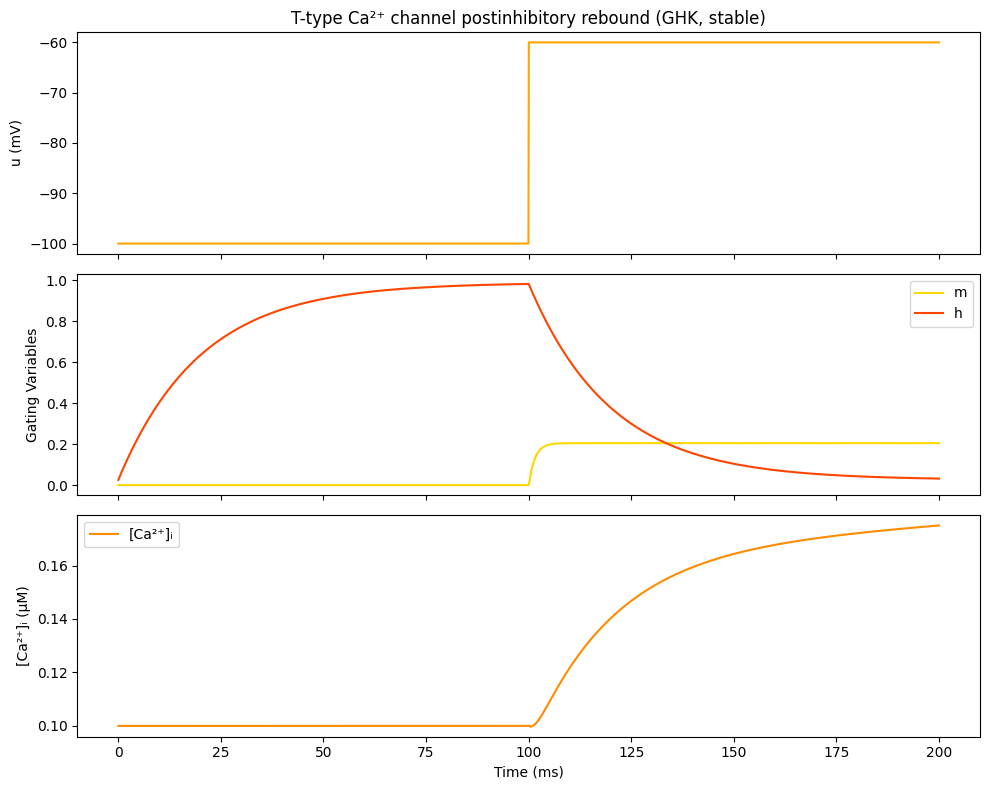

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
F = 9.648e4  # Faraday constant (C/mol)
R = 8.314  # Gas constant (J/(mol·K))
T = 310.0  # Temperature (K)
z = 2  # Valence of Ca2+
p_Ca = 1e-5  # Max permeability (cm/s)
Ca_out = 2.0  # Extracellular calcium (mM)
Ca_out_uM = Ca_out * 1e3  # Convert to µM
C_m = 1.0  # µF/cm^2

# Gating functions
def m_inf(u): return 1 / (1 + np.exp(-(u + 50) / 7.4))
def h_inf(u): return 1 / (1 + np.exp((u + 78) / 5.0))
def tau_m(u): return 1.5  # ms
def tau_h(u): return 20.0  # ms

# Voltage protocol: two-phase toggle
def voltage_protocol(t):
    return -100 if t < 100 else -60  # mV

# Safe GHK current calculation
def ghk_current(u, Ca_i, m, h):
    Ca_i_mM = Ca_i * 1e-3
    V = u * 1e-3  # Convert mV to V
    E = (z * F * V) / (R * T)
    # Use a numerically stable GHK expression
    if np.abs(E) < 1e-6:
        ghk = (Ca_i_mM - Ca_out)  # Linear approx for small E
    else:
        exp_negE = np.exp(-E)
        ghk = (Ca_i_mM - Ca_out * exp_negE) / (1 - exp_negE + 1e-9)
    return p_Ca * m**2 * h * z**2 * F**2 * V / (R * T) * ghk

# ODE system
def deriv(t, y):
    m, h, Ca_i = y
    u = voltage_protocol(t)

    m_inf_t = m_inf(u)
    h_inf_t = h_inf(u)
    dm_dt = (m_inf_t - m) / tau_m(u)
    dh_dt = (h_inf_t - h) / tau_h(u)

    I_Ca = ghk_current(u, Ca_i, m, h)  # µA/cm²
    dCa_dt = -1e3 * I_Ca / (2 * F)  # µM/ms

    return [dm_dt, dh_dt, dCa_dt]

# Initial conditions
y0 = [m_inf(-100), h_inf(-60), 0.1]  # m, h, [Ca2+]_i in µM

# Time span
t_span = (0, 200)
t_eval = np.linspace(*t_span, 2000)
sol = solve_ivp(deriv, t_span, y0, t_eval=t_eval, method='RK45')

# Extract results
m, h, Ca_i = sol.y
u = np.array([voltage_protocol(t) for t in t_eval])

# Plot
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
axs[0].plot(t_eval, u, label="u (mV)", color="orange")
axs[0].set_ylabel("u (mV)")
axs[0].set_title("T-type Ca²⁺ channel postinhibitory rebound (GHK, stable)")

axs[1].plot(t_eval, m, label="m", color="gold")
axs[1].plot(t_eval, h, label="h", color="orangered")
axs[1].set_ylabel("Gating Variables")
axs[1].legend()

axs[2].plot(t_eval, Ca_i, label="[Ca²⁺]ᵢ", color="darkorange")
axs[2].set_ylabel("[Ca²⁺]ᵢ (µM)")
axs[2].set_xlabel("Time (ms)")
axs[2].legend()

plt.tight_layout()
plt.show()



# High-Threshold Calcium Currents

In contrast to low-threshold calcium currents, which inactivate after brief activation, high-threshold calcium currents—denoted $I_L$—activate only at relatively depolarized membrane potentials (above roughly $-50 \, \text{mV}$). These channels are often referred to as “long-lasting” because they do not exhibit fast inactivation. The current through these channels is again governed by the Goldman-Hodgkin-Katz (GHK) equation, and their permeability is characterized by a gating variable $m$, which determines the fraction of open channels.

Because high-threshold channels activate only during action potentials, they play a role in driving longer-term calcium entry. This calcium influx has important downstream effects, especially on calcium-activated potassium currents. One such current, $I_C$, is activated by increases in intracellular calcium $[\text{Ca}^{2+}]_i$, and is modeled using the familiar Ohmic form:

$$
I_C = \bar{g}_C \, m \, (u - E_K)
\tag{2.13}
$$

Here, $\bar{g}_C$ is the maximal conductance, $u$ is the membrane potential, and $E_K$ is the potassium reversal potential (typically around $-85 \, \text{mV}$). The gating variable $m$ in this case depends explicitly on the intracellular calcium concentration, not on membrane voltage. Its time evolution is given by:

$$
\frac{dm}{dt} = \alpha m - \beta (1 - m)
\tag{2.14}
$$

The parameters $\alpha$ and $\beta$ themselves depend on both voltage and calcium concentration:

$$
\alpha = 2.5 \times 10^5 [\text{Ca}^{2+}]_i \, \exp(u / 24), \quad \beta = 0.1 \, \exp(-u / 24)
\tag{2.15}
$$

This dynamic implies that both the steady-state activation $m^\infty = \frac{\alpha}{\alpha + \beta}$ and the time constant $\tau_m = \frac{1}{\alpha + \beta}$ vary with membrane potential and calcium levels. As calcium rises, the activation increases and the time constant decreases, meaning that the potassium channels open more quickly and with greater magnitude. These calcium-activated potassium currents contribute to spike repolarization and neuronal adaptation.

# Calcium-Activated Adaptation: The AHP Current

A closely related mechanism is the AHP (afterhyperpolarization) current, denoted $I_{\text{AHP}}$. Like $I_C$, it is a calcium-activated potassium current, but with key differences. It is slower to activate and is **not voltage-dependent**; rather, its activation depends only on intracellular calcium concentration. This makes the AHP current ideal for generating slow, cumulative adaptation effects over multiple spikes or sustained activity.

The AHP current is described by a similar equation:

$$
I_{\text{AHP}} = \bar{g}_{\text{AHP}} \, m \, (u - E_K)
\tag{2.16}
$$

The gating variable $m$ evolves according to:

$$
\frac{dm}{dt} = \alpha m - \beta (1 - m)
\tag{2.17}
$$

but now the parameters $\alpha$ and $\beta$ are simplified to reflect calcium-only dependence. In hippocampal pyramidal neurons, a typical form is:

$$
\alpha = c \cdot \min\left([ \text{Ca}^{2+} ]_i, \, 0.01\right), \quad \beta = 0.001
$$

where $c$ is a constant. Because AHP channels are not inactivating and change slowly, each action potential adds incrementally to their activation, producing a gradual buildup of outward potassium current. This buildup counteracts continued firing, providing a form of spike-frequency adaptation that shapes the neuron’s longer-term excitability profile.
